# What to do with thousands of neurons in visual cortex?  

# 0. Loading and preparing. 

### Load in the Python libraries

In [3]:
import os # os stands for "operating system" and includes read/write routines etc. 
import numpy as np # by far the most used library for everyday computation
from scipy import stats # here we import a whole sub-library of stats functions
from scipy.ndimage import gaussian_filter, gaussian_filter1d # here we import a single function
from sklearn.decomposition import PCA # check out all the other dimensionality reduction methods in "decomposition"
from matplotlib import pyplot as plt # all of our plotting is done with plt
%matplotlib inline 
# %matplotlib notebook # if you need to zoom into a figure, this is the "interactive" mode of IPython

# this function performs a running average filter over the first dimension of X
# (faster than doing gaussian filtering)
def running_average(X, nbin = 100):
    Y = np.cumsum(X, axis=0)
    Y = Y[nbin:, :] - Y[:-nbin, :]
    return Y

# * set root to the location where you downloaded the data *
root      = 'D:/grive/cshl_suite2p/TX39/'

# LOAD the visual stimuli "mov" and the timings "iframe"
mov    = np.load(os.path.join(root, 'mov.npy')) # these are the visual stimuli shown
iframe = np.load(os.path.join(root, 'iframe.npy')) # iframe[n] is the microscope frame for the image frame n

# LOAD the neural data
spks = np.load(os.path.join(root, 'spks.npy')) # deconvolved data
stat = np.load(os.path.join(root, 'stat.npy'), allow_pickle=True) # these are the per-neuron stats returned by suite2p
# these are the neurons' 2D coordinates
ypos = np.array([stat[n]['med'][0] for n in range(len(stat))]) 
# (notice the python list comprehension [X(n) for n in range(N)])
xpos = np.array([stat[n]['med'][1] for n in range(len(stat))]) 

del stat # we delete stat because we don't need any other fields from it


### Align stimuli and neural data

In [4]:
# align stimuli to spks (since stimuli are triggered by microscope it's easy)
dt = 1 # time offset between stimulus presentation and response
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
mov = mov[:, :, ivalid]
S = spks[:, iframe+dt]
del spks
S = stats.zscore(S, axis=1) # z-score the neural activity before doing anything

# 1. Single neuron receptive fields

Let's first look at the positions of the neurons.

Text(0, 0.5, 'Y position (um)')

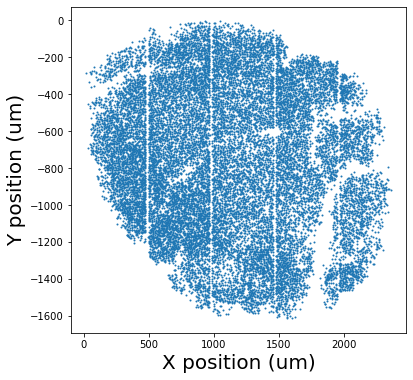

In [5]:
# POSITIONS OF ALL NEURONS
plt.figure(figsize=(6,6))
plt.scatter(xpos, -ypos, s = 1)
plt.xlabel('X position (um)', fontsize=20)
plt.ylabel('Y position (um)', fontsize=20)

And what does the stimulus look like on each frame?

In [2]:
# STIMULUS FRAME
plt.figure()
plt.imshow(mov[:,:,100], cmap='gray')
plt.title('example frame')
plt.show()

NameError: name 'plt' is not defined

Text(0.5, 0, 'time points')

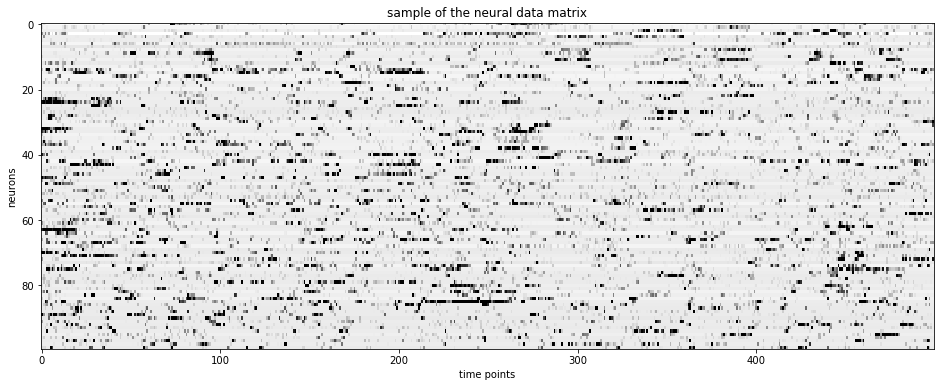

In [4]:
plt.figure(figsize=(16,6))
plt.imshow(S[:100, :500], vmax = 3, vmin = -0.5, aspect='auto', cmap = 'gray_r')
plt.title('sample of the neural data matrix')
plt.ylabel('neurons') 
plt.xlabel('time points')

### First, compute ordinary ON - OFF receptive fields for each neuron

In [5]:
NN, NT = S.shape 

X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
X = X-0.5 # center at 0
#X = np.abs(X-0.5) # center at 0
X = stats.zscore(X, axis=1)/NT**.5  # z-score each pixel separately
npix = X.shape[0]

lam = 0.01 # regularizer for ridge regression
B0 = np.linalg.solve((X @ X.T + lam * np.eye(npix)),  (X @ S.T)) # get the receptive fields for each neuron
        
B0 = np.reshape(B0, [mov.shape[0], mov.shape[1], NN])
B0 = gaussian_filter(B0, [.5, .5, 0]) # smooth each receptive field a little

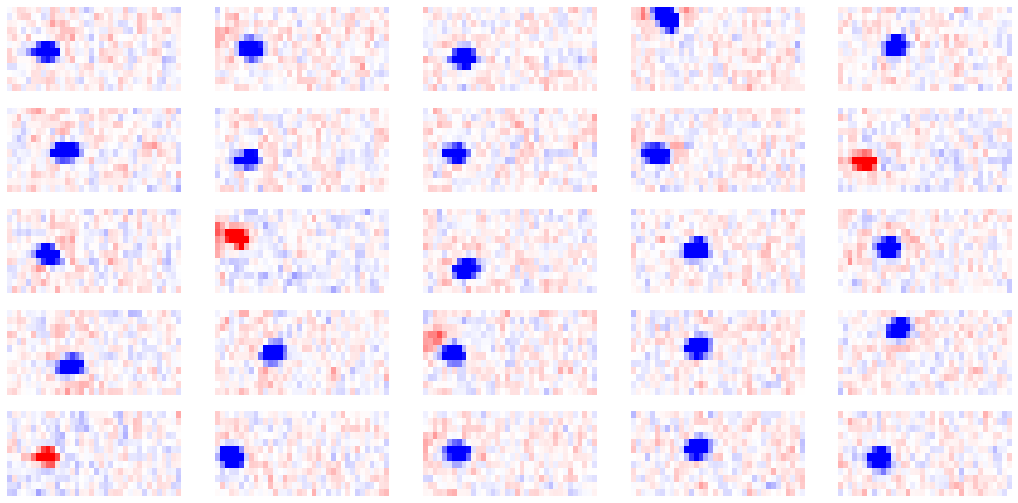

In [8]:
Spred = np.reshape(B0, (-1,NN)).T @ X
Spred -= S
varexp = 1.0 - (Spred**2).mean(axis=-1)
asort = np.argsort(varexp)[::-1]

plt.figure(figsize=(18, 9))
for j in range(5*5):
    plt.subplot(5,5,j+1)
    plt.imshow(B0[:,:,asort[j]], aspect='auto', vmin=-6, vmax=6, cmap = 'bwr') # plot the receptive field for each neuron
    plt.axis('off')  
plt.show()

### Now let's compute ON + OFF receptive fields

In [9]:
X = np.abs(X) # response is the same for ON and OFF squares (WHITE OR BLACK)

X = stats.zscore(X, axis=1)/NT**.5  # z-score each pixel separately
lam = 0.01 # regularizer for ridge regression
B0 = np.linalg.solve((X @ X.T + lam * np.eye(npix)),  (X @ S.T)) # get the receptive fields for each neuron
        
B0 = np.reshape(B0, [mov.shape[0], mov.shape[1], NN])
B0 = gaussian_filter(B0, [.5, .5, 0]) # smooth each receptive field a little

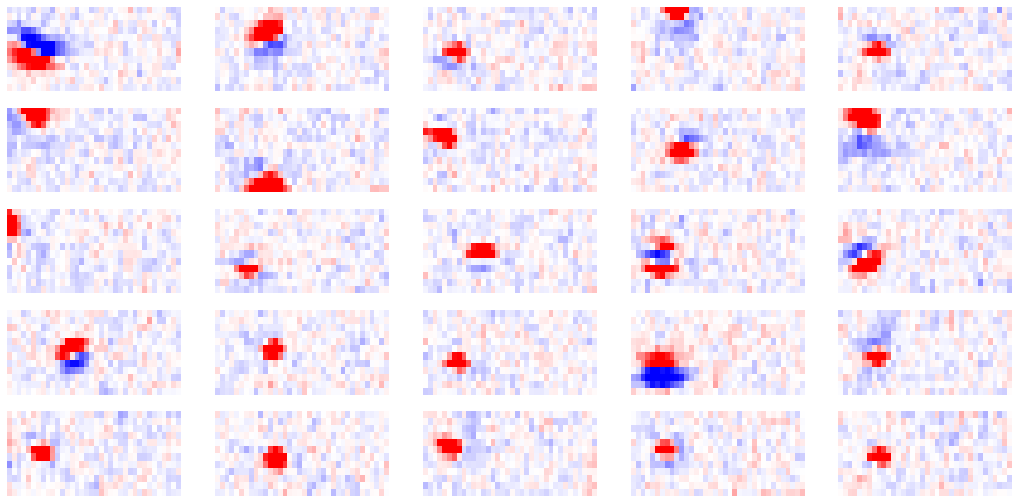

In [10]:
Spred = np.reshape(B0, (-1,NN)).T @ X
Spred -= S
varexp = 1.0 - (Spred**2).mean(axis=-1)
asort = np.argsort(varexp)[::-1]

plt.figure(figsize=(18, 9))
for j in range(5*5):
    plt.subplot(5,5,j+1)
    plt.imshow(B0[:,:,asort[j]], aspect='auto', vmin=-6, vmax=6, cmap = 'bwr') # plot the receptive field for each neuron
    plt.axis('off')   
plt.show()

## Average over RFs in local region

Create distance matrix and then average neurons within 50 um of each neuron.

In [11]:
deltay = ypos[:, np.newaxis] - ypos # np.newaxis creates a new axis
deltax = xpos[:, np.newaxis] - xpos # a vector of N by 1 can broadcast with a vector of 1 by N to give a matrix N by N
ds = (deltay**2 + deltax**2)**.5 # **2 means elementwise squaring
del deltay, deltax

# find all neurons within 50 um and average over their RFs
sig = 50 # spatial scale for smoothing
B = np.zeros(B0.shape)
for j in range(NN):
    ix = ds[:,j]<sig
    B[:,:,j] = np.mean(B0[:,:,ix], axis=-1) # average receptive fields within sig
    

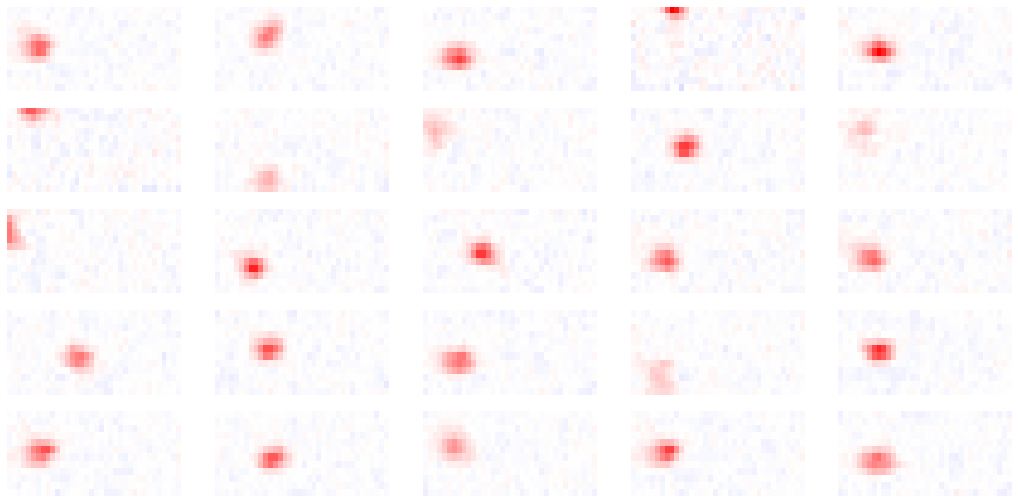

In [13]:
Spred = np.reshape(B0, (-1,NN)).T @ X
Spred -= S
varexp = 1.0 - (Spred**2).mean(axis=-1)
asort = np.argsort(varexp)[::-1]

plt.figure(figsize=(18, 9))
for j in range(5*5):
    plt.subplot(5,5,j+1)
    plt.imshow(B[:,:,asort[j]], aspect='auto', vmin=-6, vmax=6, cmap = 'bwr') # plot the receptive field for each neuron
    plt.axis('off')
    
plt.show()

Create retinotopy. Take the max of each averaged receptive field and use as receptive field location.

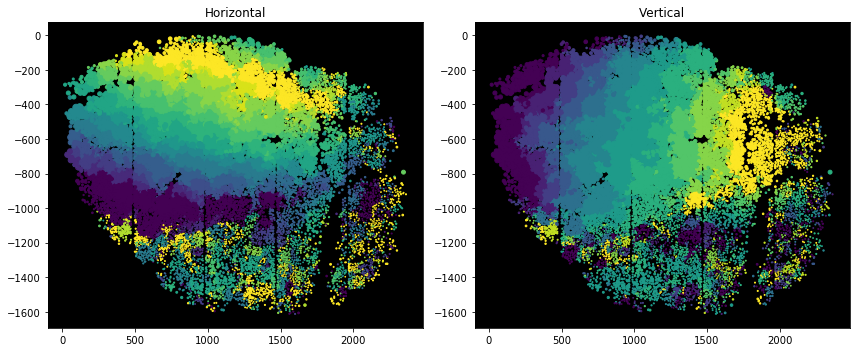

In [15]:
imax = np.argmax(np.reshape(B, [-1,NN]), axis=0) # find the pixel corresponding to the max response for each cell
ly, lx, nstim = mov.shape

# xmax, ymax = np.unravel(imax, (ly, lx)) # unravel an index for a (1,ly*lx) array, to two indices for an (ly, lx) array
xmax = np.minimum(17, imax%lx)
ymax = (imax/lx).astype('int')

plt.figure(figsize=(12,5))
Amax = np.max(B, axis=(0,1)) - np.min(B, axis=(0,1))
plt.subplot(1,2,1, facecolor=[0, 0, 0])
plt.scatter(xpos, -ypos, s = (Amax)**2, c = xmax, cmap='viridis')
plt.title('Horizontal')

plt.subplot(1,2,2, facecolor=[0, 0, 0])
plt.scatter(xpos, -ypos, s = (Amax)**2, c = ymax, cmap='viridis')
plt.title('Vertical')

plt.tight_layout()

plt.show()

# 2. Dimensionality reduction: what are the dominant patterns of activity?

Let's look at the top PCs

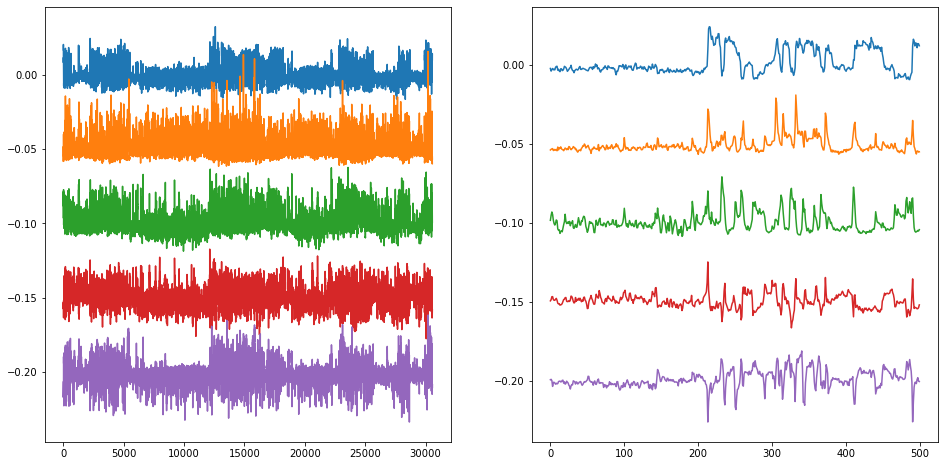

In [4]:
# show that components do not necessarily have receptive fields
from sklearn.decomposition import PCA
model = PCA(n_components = 100)
model.fit(S)

# plot some components
X = model.components_

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
for j in range(5):
    plt.plot(X[j] - j * .05)
plt.subplot(1,2,2)
for j in range(5):
    plt.plot(X[j, 2000:2500] - j * .05)
plt.show()

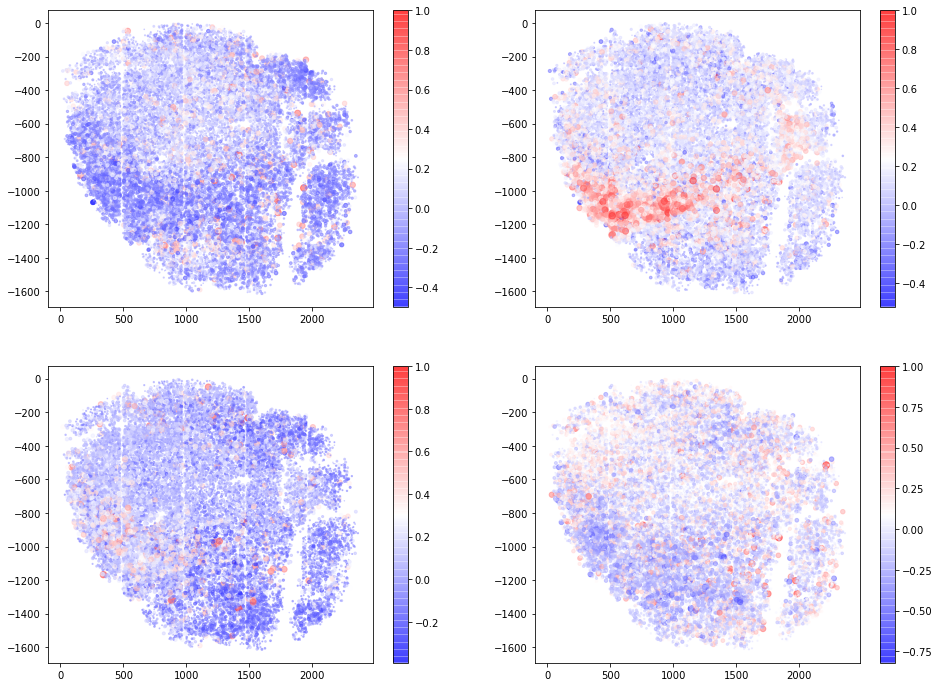

In [5]:
# HERE color cells according to their PC weights
plt.figure(figsize=(16,12))
for j in range(4):
    pc0 = S @ model.components_[j]
    pc0 = pc0/np.max(np.abs(pc0))
    lam = np.abs(pc0)    
    plt.subplot(2,2,1+j)
    plt.scatter(xpos, -ypos, s = 50 * lam, c = pc0, cmap='bwr', alpha = .5)
    plt.colorbar()

Receptive fields of the PCs:

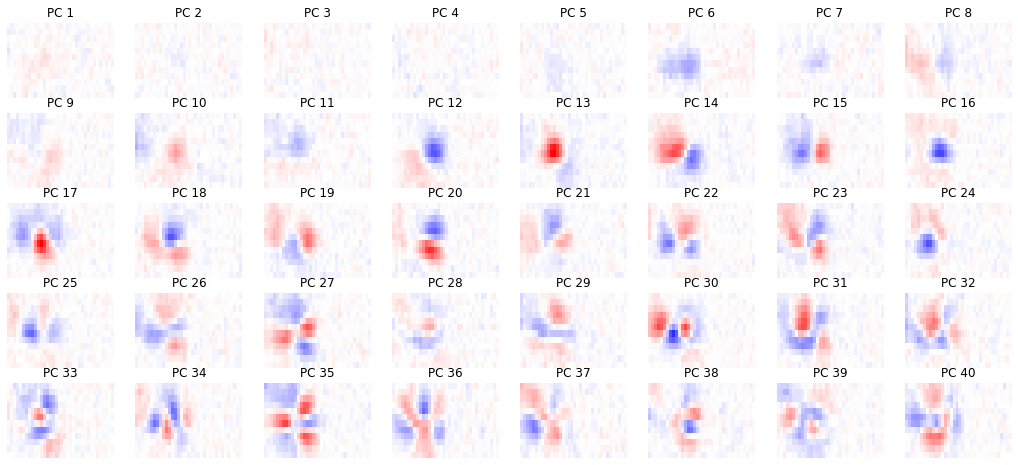

In [7]:
from scipy.stats import zscore
Sp = model.components_
Sp = zscore(Sp, axis=1)
ly, lx, nstim = mov.shape

NN, NT = S.shape 

X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
X = X-0.5 # subtract the background
X = np.abs(X) # does not matter if a pixel is black (0) or white (1)
X = stats.zscore(X, axis=1)/NT**.5  # z-score each pixel separately
npix = X.shape[0]

lam = .0001
ncomps = Sp.shape[0]
B0 = np.linalg.solve((X @ X.T + lam * np.eye(npix)),  (X @ Sp.T)) # get the receptive fields for each neuron

B0 = np.reshape(B0, (ly, lx, ncomps))
B0 = gaussian_filter(B0, [.5, .5, 0]) # smooth each receptive field a little

plt.figure(figsize=(18, 8))
rfmax = np.max(B0)
for j in range(40):
    plt.subplot(5,8,j+1)
    rf = B0[:,:,j]
    # rfmax = np.max(np.abs(rf))
    plt.imshow(rf, aspect='auto', cmap = 'bwr', vmin = -rfmax, vmax = rfmax) # plot the receptive field for each neuron
    plt.title('PC %d'%(1+j))
    plt.axis('off')
    
plt.show()    

## Two mysteries

1. Why don't the top PCs have receptive fields?
2. Why do the PC receptive fields look like that?
    - PCs of translation-invariant data always look like that


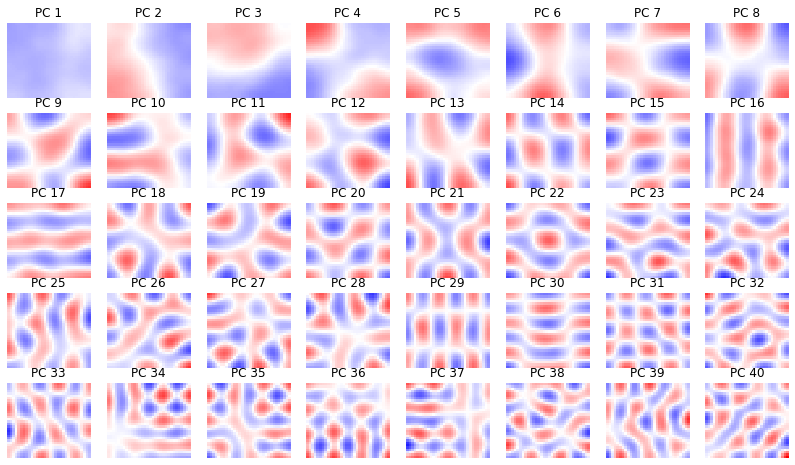

In [8]:
# solve the second mystery: PCA of translation-invariant data always looks like that
# make some random noise and smooth it
nPC = 50

Xn = np.random.randn(10000, 32,32)
Xn = gaussian_filter(Xn, [0, 2, 2])
Xn = np.reshape(Xn, (10000, -1))
model = PCA(n_components= nPC).fit(Xn)

bPC = np.reshape(model.components_.T, (32,32, nPC))
plt.figure(figsize=(14, 8))
rfmax = np.max(bPC)
for j in range(40):
    plt.subplot(5,8,j+1)
    rf = bPC[:,:,j]
    # rfmax = np.max(np.abs(rf))
    plt.imshow(rf, aspect='auto', cmap = 'bwr', vmin = -rfmax, vmax = rfmax) # plot the receptive field for each neuron
    plt.title('PC %d'%(1+j))    
    plt.axis('off')
plt.show()    

# compare with DCT https://en.wikipedia.org/wiki/Discrete_cosine_transform
del Xn    

# 3. Rastermap

Rastermap re-arranges neurons in the raster plot based on similarity of activity

We can first run rastermap in suite2p and then in the notebook.

In [1]:
from rastermap import Rastermap

# we run rastermap the same way that the other scikit-learn embedding algorithms work
model = Rastermap(n_components=1, n_X=100).fit(S) 

NameError: name 'S' is not defined

In [58]:
# the manifold embedding is in model.embedding
isort = np.argsort(model.embedding[:,0])

# sort by embedding and smooth over neurons
Sfilt = running_average(S[isort, 2000:2500], 50)
Sfilt = stats.zscore(Sfilt, axis=1)

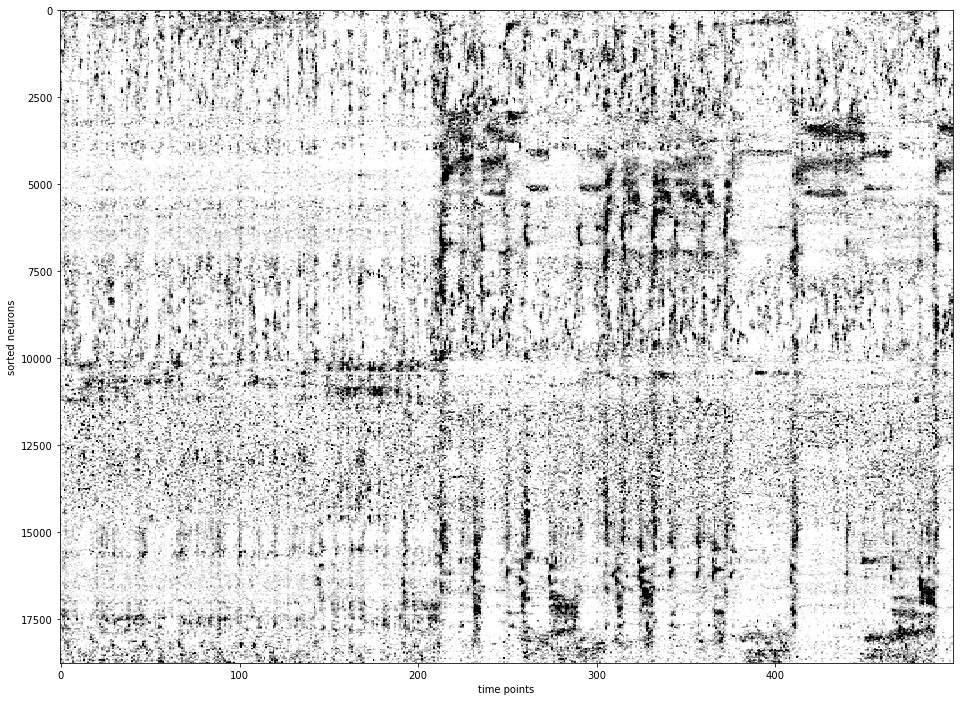

In [59]:
plt.figure(figsize=(16,12))
plt.imshow(Sfilt, vmin = -0.5, vmax=3, aspect='auto', cmap='gray_r')
plt.xlabel('time points')
plt.ylabel('sorted neurons')
plt.show()

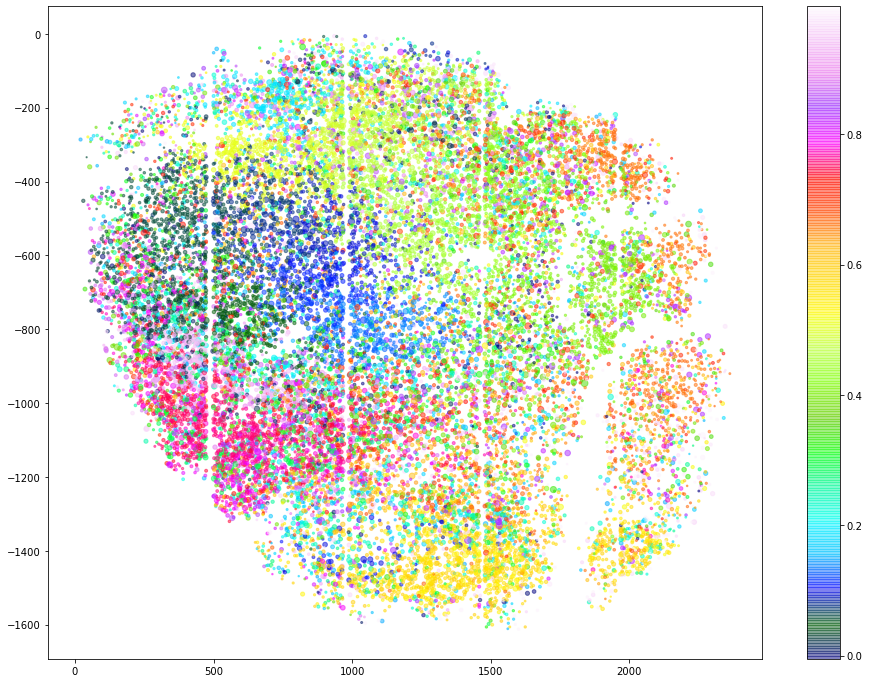

In [66]:
# HERE color cells according to their rastermap embedding
lam=model.lam
plt.figure(figsize=(16,12))
plt.scatter(xpos, -ypos, s=50*lam/np.max(lam), c=model.embedding[:,0], 
            cmap='gist_ncar', alpha = .5)
plt.colorbar()
plt.show()

Do the rastermap components have receptive fields?

In [24]:
NN, NT = S.shape 

# reshape and sum S across neurons to get "components"
nc = 100
NC = int(np.floor(NN / nc))
Sp = np.reshape(S[isort][:nc*NC], (NC, nc, NT))
Sp = Sp.mean(axis=1)

ly, lx, nstim = mov.shape

X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
X = np.abs(X-0.5) # does not matter if a pixel is black (0) or white (1)
X = stats.zscore(X, axis=1)/NT**.5  # z-score each pixel separately
npix = X.shape[0]

lam = .01
ncomps = Sp.shape[0]
B0 = np.linalg.solve((X @ X.T + lam * np.eye(npix)),  (X @ Sp.T)) # get the receptive fields for each neuron

B0 = np.reshape(B0, (ly, lx, ncomps))
B0 = gaussian_filter(B0, [.5, .5, 0]) # smooth each receptive field a little

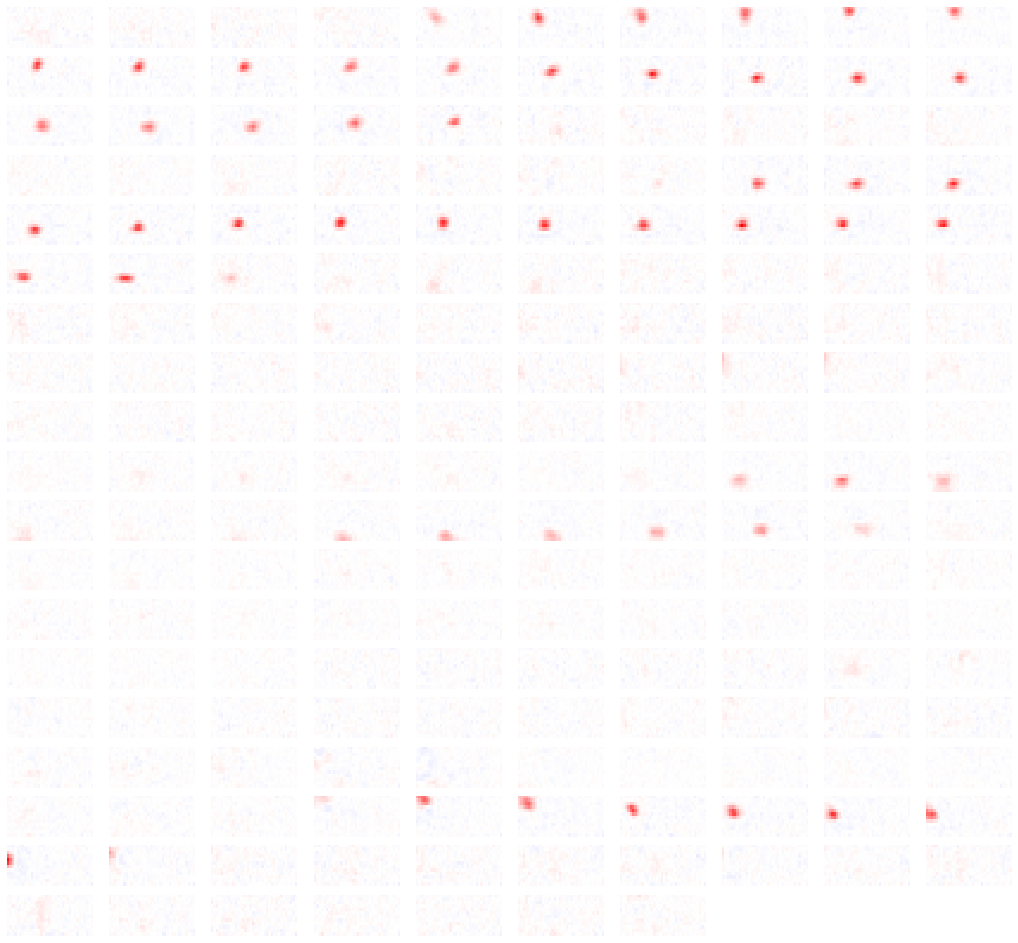

In [81]:
# plot receptive fields
plt.figure(figsize=(18, 18))
rfmax = np.max(B0)
for j in range(0, B0.shape[-1]):
    plt.subplot(20,10,j+1)
    rf = B0[:,:,j]
    # rfmax = np.max(np.abs(rf))
    plt.imshow(rf, aspect='auto', cmap = 'bwr', vmin = -rfmax, vmax = rfmax) # plot the receptive field for each neuron    
    plt.axis('off')
    
plt.show()    

# 4. Behavioral analysis

What are these other groups of neurons responding to?

In [28]:
# LOAD IN BEHAVIORAL DATA
proc = np.load(os.path.join(root, 'cam1_TX39_2019_05_31_1_proc_resampled.npy'), allow_pickle=True).item()
motSVD = proc['motSVD'][:,iframe+dt]
parea = proc['pupil']['area'][0][iframe+dt].copy()

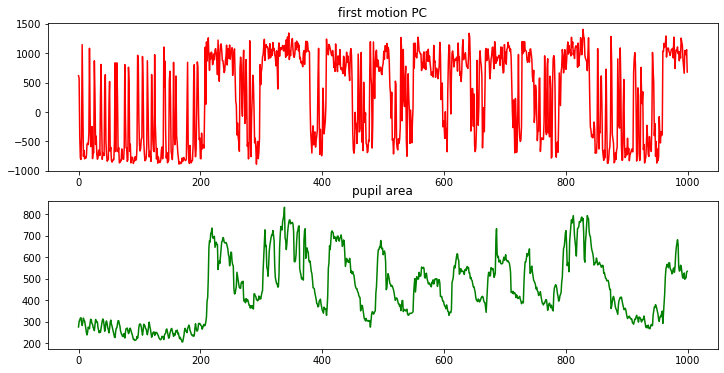

In [17]:
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(motSVD[0,2000:3000]*-1, color='r')
plt.title('first motion PC')

plt.subplot(2,1,2)
plt.plot(parea[2000:3000], color='g')
plt.title('pupil area')
plt.show()

### Bin neural and behavioral data
We will bin the neural activity and the behavior (1 second bins)

In [33]:
# bin data
tbin = 3.0
NT = motSVD.shape[1]
nt = int(np.floor(NT/tbin))
motSVD -= motSVD.mean(axis=1)[:,np.newaxis]
parea  -= np.nanmean(parea)
parea[np.isnan(parea)] = 0
tbin = int(tbin)

beh = np.reshape(motSVD[:,:nt*tbin], (motSVD.shape[0], nt, tbin)).mean(axis=-1)
pup = np.reshape(parea[:nt*tbin], (nt, tbin)).mean(axis=-1)

# using this format bin S
Sbin = np.reshape(S[:,:nt*tbin], (S.shape[0], nt, tbin)).mean(axis=-1)
Spbin = np.reshape(Sp[:,:nt*tbin], (Sp.shape[0], nt, tbin)).mean(axis=-1)

# use PCs of neural activity
model = PCA(n_components=64).fit(Sbin)
V = model.components_ # time components
sv = model.singular_values_
U = np.matmul(Sbin,V.T) / sv # neuron components
V *= sv[:,np.newaxis]

We have to do a train-test split to do prediction

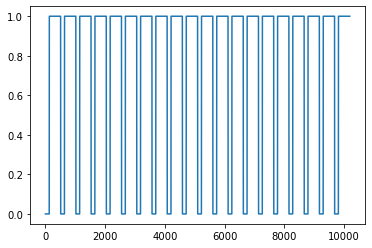

In [34]:
# split into train-test
# * use interleaved segments *
nsegs = 20
nlen  = nt/nsegs
ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
itrain = np.ones(nt, np.bool)
itrain[itest] = 0

plt.plot(itrain)
plt.show()

Can you determine how I did the split above? Why might I have split into segments rather than randomly interleaving time-points?

# Prediction with behavioral variables

Use linear regression to perform the prediction, predict $Y$ using $X$:

$$ A = (X_\text{train}X_\text{train}^\top)^{-1} (X_\text{train} Y_\text{train}^\top)$$

$X$ is behavioral components by time, $Y$ is neural components by time. If you want to regularize the linear regression:

$$ A = (X_\text{train}X_\text{train}^\top + \lambda I)^{-1} (X_\text{train} Y_\text{train}^\top)$$

Then the prediction on time points is:

$$ \hat Y_\text{test} = A^\top X_\text{test} $$

In [35]:
#### PREDICT USING PUPIL WITH LINEAR REGRESSION

A = np.matmul(pup[itrain], V[:,itrain].T)/(pup**2).sum()

Vpredp = np.matmul(A[:,np.newaxis], pup[itest][np.newaxis,:])

varexp_pupil = 1 - ((Vpredp - V[:,itest])**2).sum(axis=1)/(V[:,itest]**2).sum(axis=1)

#### PREDICT USING BEHAVIOR PC'S 
## regularized linear regression from behavior to neural PCs
covM = np.matmul(beh[:,itrain], beh[:,itrain].T)
lam = 1e5 # regularizer
covM += lam*np.eye(beh.shape[0])
A = np.linalg.solve(covM, np.matmul(beh[:,itrain], V[:,itrain].T))

Vpred = np.matmul(A.T, beh[:,itest])

varexp = 1 - ((Vpred - V[:,itest])**2).sum(axis=1)/(V[:,itest]**2).sum(axis=1)

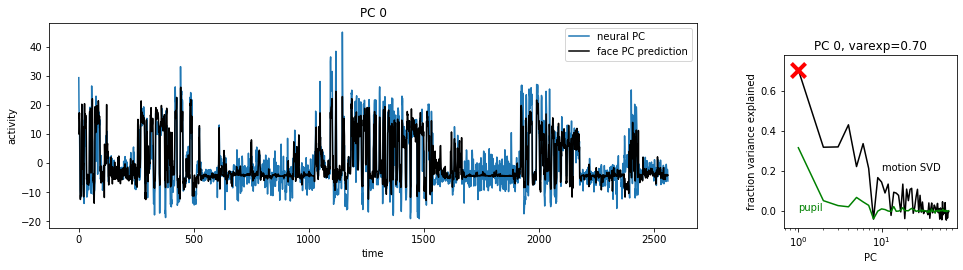

In [36]:
# plot of principal component activity and variance explained

fig=plt.figure(figsize=(12,3))

ipc = 0 ### which PC to plot

ax = fig.add_axes([0.05,.05,.75,.95])
ax.plot(V[ipc,itest], label='neural PC')
ax.plot(Vpred[ipc], color='k', label='face PC prediction')
ax.set_title('PC %d'%ipc)
ax.set_xlabel('time')
ax.set_ylabel('activity')
ax.legend()

ax = fig.add_axes([0.9,.05, .2, .8])
ax.semilogx(np.arange(1,varexp.size+1), varexp, color='k')
ax.scatter(ipc+1, varexp[ipc],marker='x',color='r',s=200, lw=4, zorder=10)
ax.semilogx(np.arange(1,varexp.size+1), varexp_pupil, color=[0.,.5,0])
ax.text(1,0,'pupil',color=[0,.5,0])
ax.text(10,0.2,'motion SVD')
ax.set_xlabel('PC')
ax.set_ylabel('fraction variance explained')
ax.set_title('PC %d, varexp=%0.2f'%(ipc,varexp[ipc]))
plt.show()

In [38]:
# sort data by rastermap + smooth
Sfilt = running_average(Sbin[isort][:,itest])
Sfilt = stats.zscore(Sfilt, axis=1)

Spred = np.matmul(U, Vpred)
Sfilt_pred = running_average(Spred[isort, :])
Sfilt_pred = stats.zscore(Sfilt_pred, axis=1)

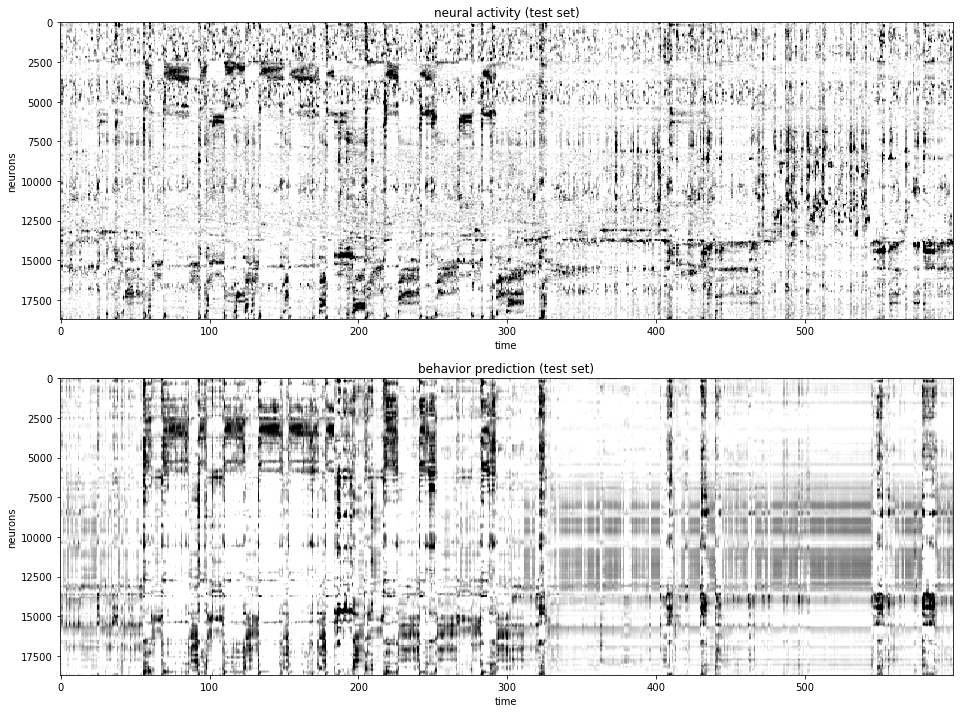

In [39]:
### plot data + prediction
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(2,1,1)
ax.imshow(Sfilt[:,200:800], vmin = -.5, vmax=3, aspect='auto', cmap = 'gray_r')
ax.set_xlabel('time')
ax.set_ylabel('neurons')
ax.set_title('neural activity (test set)')

ax = fig.add_subplot(2,1,2)
ax.imshow(Sfilt_pred[:,200:800], vmin = -.5, vmax=3, aspect='auto', cmap = 'gray_r')
ax.set_xlabel('time')
ax.set_ylabel('neurons')
ax.set_title('behavior prediction (test set)')

plt.show()

how good is the behavioral prediction across the rastermap?

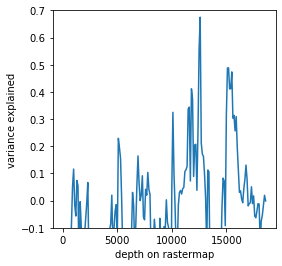

In [72]:
# bin across the rastermap in groups of 100 neurons
Spbin_pred = np.reshape(Spred[isort][:nc*NC,:], (NC, nc, -1)).mean(axis=1)
Spbin_pred -= Spbin[:,itest]

varexp_RM = 1 - Spbin_pred.var(axis=1) / Spbin.var(axis=1)

#Spbin_pred = zscore(Spbin_pred, axis=1)
#Spbin = zscore(Spbin, axis=1)
#cc = np.matmul(Spbin, Spbin_pred.T) / Spbin.shape[-1]
#cpred = np.diag(cc)

# prediction quality across the rastermap
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(0,Spbin.shape[0])*nc, varexp_RM[::-1])
ax.set_ylim([-.1,0.7])
ax.set_ylabel('variance explained')
ax.set_xlabel('depth on rastermap')
plt.show()